# Recurrent Neural Networks
Or as I like to call them, neural networks in a for loop, they allow us to make predictions on sequential data with varying lenghts, it simple breakes the whold data sequesnce into distinguishable sets and performs inference or trainin on them one after the other.

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

### Working with sequences
Working with sequences models involves tryingn to predict the next sequence given a list of previous sequences from inside a context window.

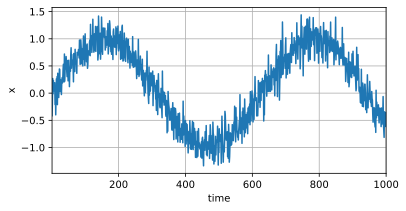

In [4]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = tf.range(1, T+1, dtype=tf.float32)
        self.x = tf.sin(0.01*self.time) + tf.random.normal([T]) * 0.2
        
    def get_dataloader(self, train):
        features = [self.x[i: self.T - self.tau + i] for i in range(self.tau)]
        self.features = tf.stack(features, 1)
        self.labels = tf.reshape(self.x[self.tau:], (-1, 1))
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader([self.features, self.labels], train, i)
    
data = Data()
d2l.plot(data.time, data.x, 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

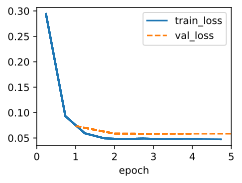

In [5]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

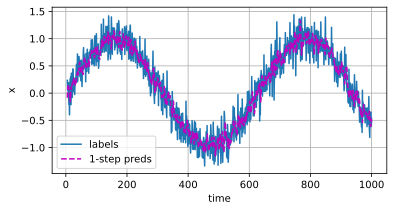

In [6]:
# Testing how our model performs one step ahead
onestep_preds = model(data.features).numpy()
d2l.plot(data.time[data.tau:], [data.labels, onestep_preds], 'time', 'x', legend=['labels', '1-step preds'], figsize=(6, 3))


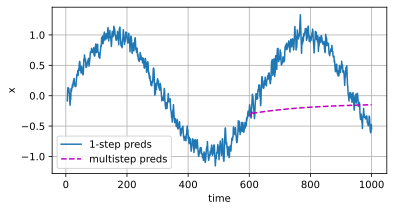

In [7]:
multistep_preds = tf.Variable(tf.zeros(data.T))
multistep_preds[:].assign(data.x)
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i].assign(tf.reshape(model(tf.reshape(multistep_preds[i-data.tau:i], (1, -1))), ()))

d2l.plot([data.time[data.tau:], data.time[data.num_train+data.tau:]],
         [onestep_preds, multistep_preds[data.num_train+data.tau:]], 'time',
         'x', legend=['1-step preds', 'multistep preds'],figsize=(6, 3))

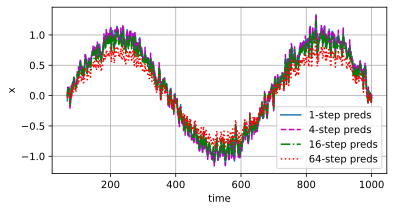

In [8]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i+data.T-data.tau-k+1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(tf.stack(features[i : i+data.tau], 1))
        features.append(tf.reshape(preds, -1))
    return features[data.tau:]

steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(data.time[data.tau+steps[-1]-1:],
         [preds[k - 1].numpy() for k in steps], 'time', 'x',
         legend=[f'{k}-step preds' for k in steps], figsize=(6, 3))